# NeuroEvolution of Augmenting Topologies (NEAT)
Evolving the weights and the topologies of a Neural Networks using the NEAT algorithm.

In [33]:
import sys
import os
import numpy as np
import neat
import importlib
import pickle

# Add the parent directory to the Python path
sys.path.append(os.path.abspath('../'))
import environment 
import utils
importlib.reload(environment)
importlib.reload(utils)

<module 'utils' from '/Users/lorenzoleuzzi/Documents/GitHub/lifelong_evolutionary_swarms/utils.py'>

In [34]:
easy_initial_setting = {
            'agents': np.array([[0, 5], [0, 10], [0, 15]], dtype=float),
            'headings': np.array([environment.DOWN, environment.DOWN, environment.DOWN], dtype=float),
            'blocks': np.array([[9, 16], [10, 12], [11, 6]], dtype=float),
            'colors': np.array([environment.RED, environment.GREEN, environment.RED], dtype=int)
            }

In [70]:
np.random.seed(seed=42)
n_blocks = 6
red_blocks = np.random.randint(3, environment.SIMULATION_ARENA_SIZE - 3, (int(n_blocks/2), 2))
other_blocks = np.random.randint(3, environment.SIMULATION_ARENA_SIZE - 3, (int(n_blocks/2), 2))
other_blocks_color = np.random.randint(4, 7, int(n_blocks/2))
initial_blocks = np.concatenate((red_blocks, other_blocks), axis=0)
initial_colors = np.concatenate((np.full(3, environment.RED), other_blocks_color), axis=0)
initial_setting = {
   'agents': np.array([[0, 5], [0, 10], [0, 15]], dtype=float),
   'headings': np.array([environment.DOWN, environment.DOWN, environment.DOWN], dtype=float),
   'blocks': np.array(initial_blocks, dtype=float),
   'colors': np.array(initial_colors, dtype=int),
}

env = environment.Environment(objective = [(environment.RED, environment.UP)],
                   size = environment.SIMULATION_ARENA_SIZE, 
                   n_agents = 3, 
                   n_blocks = 3, # n_blocks,
                   n_neighbors = 3,
                   sensor_range = environment.SIMULATION_SENSOR_RANGE,
                   sensor_angle = 360,
                   max_wheel_velocity=  environment.SIMULATION_MAX_WHEEL_VELOCITY,
                   sensitivity = 0.2,
                   initial_setting = easy_initial_setting)
env.reset()
env.print_env()

. . . . . 0 . . . . 1 . . . . 2 . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . O . . .
. . . . . . . . . . . . O . . . . . . .
. . . . . . O . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .



In [84]:
import time

In [92]:
def calculate_fitnesses_neat(genomes, config, n_steps = 100, verbose=False):
    flag_done = False
    best_steps = n_steps

    for genome_id, genome in genomes:
        genome.fitness = 0.0
        
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        obs, _ = env.reset()
        if verbose: env.print_env()

        for step in range(n_steps):
            nn_inputs = env.process_observation(obs)
            nn_outputs = [net.activate(nn_input) for nn_input in nn_inputs]
            actions = np.dot(nn_outputs, env.max_wheel_velocity)

            obs, reward, done, _, _ = env.step(actions)
            genome.fitness += reward

            if verbose:
                # print("NN inputs: ", nn_inputs)
                print("Action: ", actions)
                print("\nStep", step)
                env.print_env()
                print("Observation: ", obs)
                print("Reward: ", reward)
            
            if done:
                genome.fitness += (n_steps - step) / 2
                flag_done = True
                if best_steps > step:
                    best_steps = step
                break
        
    if flag_done:
        print(f"Done in {best_steps} steps")

In [93]:
# Set configuration file
config_path = "neat_config.txt"
config = neat.config.Config(neat.DefaultGenome, neat.DefaultReproduction,
                            neat.DefaultSpeciesSet, neat.DefaultStagnation, config_path)
# config.num_inputs = (env.n_types + 1 + 2) * env.n_neighbors + 2 + 8
# Create core evolution algorithm class
p = neat.Population(config)

# Add reporter for fancy statistical result
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)

In [94]:
# Run NEAT
winner = p.run(calculate_fitnesses_neat, 100)


 ****** Running generation 0 ****** 

Time obs: 0.8152036666870117, time net: 1.7202520370483398, time step: 4.534942865371704
Population's average fitness: -102.03906 stdev: 97.25439
Best fitness: 2.94240 - size: (3, 147) - species 1 - id 39
Average adjusted fitness: 0.628
Mean genetic distance 1.202, standard deviation 0.254
Population of 100 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   100      2.9    0.628     0
Total extinctions: 0
Generation time: 7.240 sec

 ****** Running generation 1 ****** 



KeyboardInterrupt: 

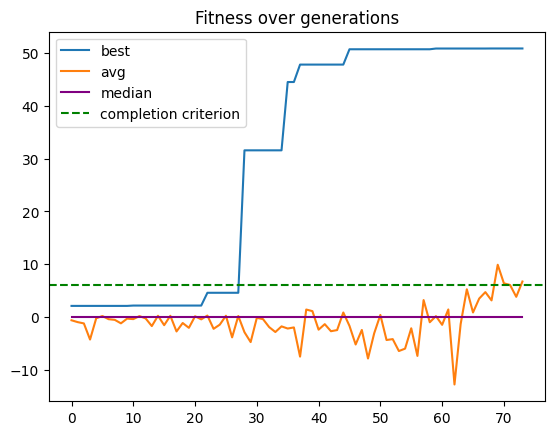

In [6]:
# Plot stats
bests = stats.get_fitness_stat(np.max)
avgs = stats.get_fitness_mean()
medians = stats.get_fitness_median()
stds = stats.get_fitness_stdev()
utils.plot_data(bests, avgs = avgs, medians = medians, 
                completion_fitness=env.n_task * (environment.REWARD_PICK + environment.REWARD_DROP))

Visualize the behaviour of the best individual

In [69]:
# read pickle
with open('../results/winners/neat_hard_202_best.pkl', 'rb') as f:
    winner = pickle.load(f)

In [81]:
calculate_fitnesses_neat([(1, winner)], config, verbose=True, n_steps=200)
winner.fitness

. . . . . 0 . . . . 1 . . . . 2 . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . O . . .
. . . . . . . . . . . . O . . . . . . .
. . . . . . O . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .

Action:  [[-3.95692753  3.99683316  3.99895236]
 [-3.95692753  3.99683316  3.99895236]
 [-3.95692753  3.99683316  3.99895236]]

Step 0
. . . . 0 . . . . 1 . . . . 2 . . . . .
. . . . . . . . . . . . 

Action:  [[-3.39487524 -3.96247486  3.90012127]
 [-3.99825436  3.99502001  3.99388156]
 [ 3.99989889 -3.99986951 -3.95737235]]

Step 49
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . 2 . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . 0 . . . . . . . . . . O . . .
. . . . . . . . . . . . O . . . . . . .
. . . . . . O . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . 1 . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . .

Observation:  [{'neighbors': array([[  3.        ,   3.65972951

0.00010000000000000286